In [2]:
from google.colab import files
import os
#if you've already uploaded kaggle.json before, don't do it again
if not(os.path.exists("kaggle.json")):
  files.upload() #upload kaggle.json
!pip install --upgrade --force-reinstall --no-deps kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 58 kB 4.8 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73051 sha256=72a01fb9fdbc6c71699be5eed5496983f54f1d7fecf1897e2ebd5e4c0c5fc83f
  Stored in directory: /root/.cache/pip/wheels/62/d6/58/5853130f941e75b2177d281eb7e44b4a98ed46dd155f556dc5
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12
kaggle.json


In [5]:
!rm -rf ./data
!kaggle datasets download phylake1337/fire-dataset -p /content/data/dataset-1 --unzip
!kaggle datasets download ashutosh69/fire-and-smoke-dataset -p /content/data/dataset-2 --unzip

 94% 366M/387M [00:01<00:00, 305MB/s]
100% 387M/387M [00:01<00:00, 300MB/s]
 93% 233M/252M [00:00<00:00, 343MB/s]
100% 252M/252M [00:00<00:00, 302MB/s]


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import os
import tensorflow as tf
from tensorflow.keras.preprocessing import image

sns.set_style('darkgrid')



import numpy as np 
import matplotlib.pyplot as plt
import glob
import cv2

from keras.models import Model, Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
import os
import seaborn as sns
from keras.applications.vgg16 import VGG16


## Dataset

In [3]:
df = pd.DataFrame(columns=['path','label'])


def populate_df(df, label, paths=[]):
  for path in paths:
    for dirname, _, filenames in os.walk(path):
      for filename in filenames:
        df = df.append(pd.DataFrame([[os.path.join(dirname, filename), label]],columns=['path','label']))
  return df



df = populate_df(df, 'fire', ['/content/data/dataset-1/fire_dataset/fire_images', '/content/data/dataset-2/data/data/img_data/test/fire', '/content/data/dataset-2/data/data/img_data/train/fire'])
df = populate_df(df, 'neither', ['/content/data/dataset-1/fire_dataset/non_fire_images', '/content/data/dataset-2/data/data/img_data/test/default', '/content/data/dataset-2/data/data/img_data/train/default'])
df = populate_df(df, 'smoke', ['/content/data/dataset-2/data/data/img_data/test/smoke', '/content/data/dataset-2/data/data/img_data/train/smoke'])
#shuffle the dataset for redistribute the labels
df = df.sample(frac=1).reset_index(drop=True)
df.head(10)

,path,label
0,/content/data/dataset-1/fire_dataset/non_fire_...,neither
1,/content/data/dataset-1/fire_dataset/non_fire_...,neither
2,/content/data/dataset-2/data/data/img_data/tes...,neither
3,/content/data/dataset-2/data/data/img_data/tra...,fire
4,/content/data/dataset-2/data/data/img_data/tra...,neither
5,/content/data/dataset-2/data/data/img_data/tes...,neither
6,/content/data/dataset-2/data/data/img_data/tra...,smoke
7,/content/data/dataset-1/fire_dataset/fire_imag...,fire
8,/content/data/dataset-2/data/data/img_data/tra...,smoke
9,/content/data/dataset-2/data/data/img_data/tra...,fire


In [4]:
fig = make_subplots(rows=1, cols=2, specs=[[{"type": "xy"}, {"type": "pie"}]])


fig.add_trace(go.Bar(x =df['label'].value_counts().index,y=df['label'].value_counts().to_numpy(),marker_color=['darkorange','green'],showlegend=False),row=1,col=1)

fig.add_trace(go.Pie(
     values=df['label'].value_counts().to_numpy(),
     labels=df['label'].value_counts().index,
    marker=dict(colors=['darkorange','green'])),
    row=1, col=2)


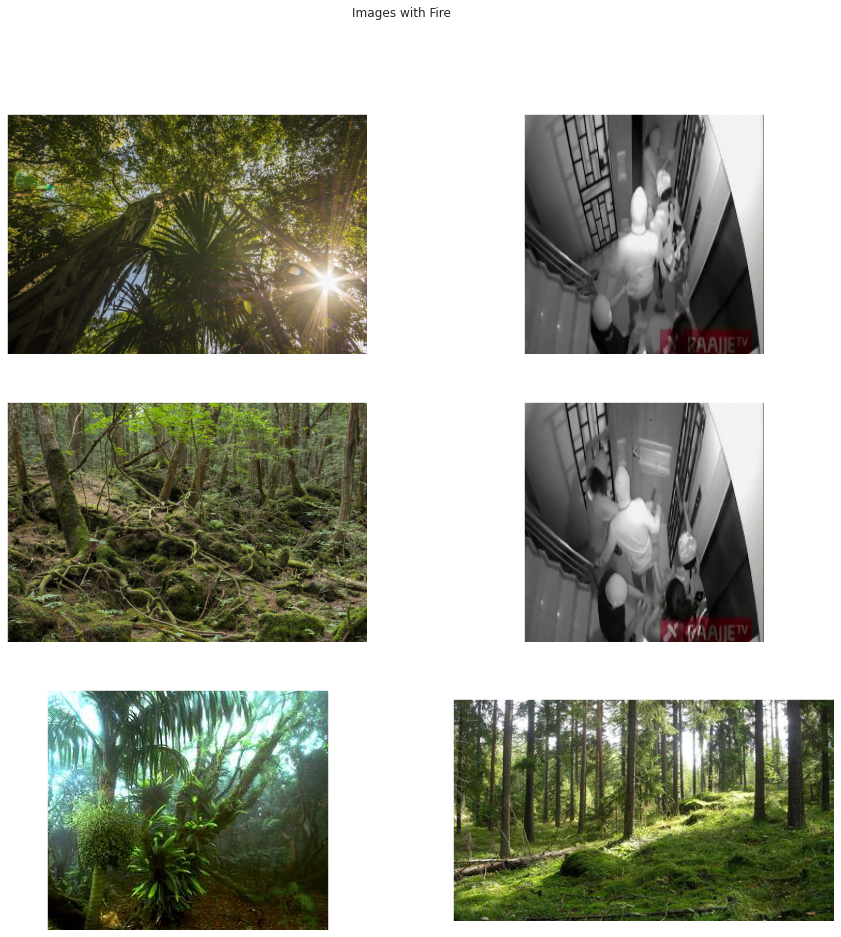

In [5]:
label = 'neither'
data = df[df['label'] == label]
sns.set_style('dark')


pics = 6 #set the number of pics
fig,ax = plt.subplots(int(pics//2),2,figsize=(15,15))
plt.suptitle('Images with Fire')
ax = ax.ravel()
for i in range((pics//2)*2):
    path = data.sample(1).loc[:,'path'].to_numpy()[0]
    img = image.load_img(path)
    img = image.img_to_array(img)/255
    ax[i].imshow(img)
    ax[i].axes.xaxis.set_visible(False)
    ax[i].axes.yaxis.set_visible(False)

In [6]:
def shaper(row):
    shape = image.load_img(row['path']).size
    row['height'] = shape[1]
    row['width'] = shape[0]
    return row
df = df.apply(shaper,axis=1)
df.head(5)

,path,label,height,width
0,/content/data/dataset-1/fire_dataset/non_fire_...,neither,1000,1500
1,/content/data/dataset-1/fire_dataset/non_fire_...,neither,533,800
2,/content/data/dataset-2/data/data/img_data/tes...,neither,224,224
3,/content/data/dataset-2/data/data/img_data/tra...,fire,540,960
4,/content/data/dataset-2/data/data/img_data/tra...,neither,224,224


In [17]:
!pip install xgboost  

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
SIZE = 300  #Resize images 

In [8]:
X = []
y = []


for index, row in df.iterrows():
    path = row[0]
    label = row[1]
    img = cv2.imread(path, cv2.IMREAD_COLOR)       
    if img is not None:
        img = cv2.resize(img, (SIZE, SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        X.append(img)
        y.append(label)

# Convert lists to arrays        
X = np.array(X)
y = np.array(y)

In [9]:
len(X), len(y)

(2217, 2217)

In [10]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()

le.fit(y)

labels_encoded = le.transform(y)

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, labels_encoded, test_size=0.33, random_state=42)

In [12]:
X_train, X_test = X_train / 255.0, X_test / 255.0

In [13]:
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

VGG_model = VGG16(weights='imagenet', include_top=False, input_shape=(SIZE, SIZE, 3))

#Make loaded layers as non-trainable. This is important as we want to work with pre-trained weights
for layer in VGG_model.layers:
    layer.trainable = False

In [49]:
VGG_model.summary()  #Trainable parameters will be 0

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 300, 300, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 300, 300, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 150, 150, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 150, 150, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 150, 150, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 75, 75, 128)       0     

In [14]:

#Now, let us use features from convolutional network for RF
feature_extractor=VGG_model.predict(X_train)

features = feature_extractor.reshape(feature_extractor.shape[0], -1)

X_for_training = features #This is our X input to RF


In [15]:
import xgboost as xgb
model = xgb.XGBClassifier()
model.fit(X_for_training, y_train) #For sklearn no one hot encoding


XGBClassifier(objective='multi:softprob')

In [16]:
#Send test data through same feature extractor process
X_test_feature = VGG_model.predict(X_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)

In [17]:
#Now predict using the trained RF model. 
prediction = model.predict(X_test_features)

In [18]:


#Inverse le transform to get original label back. 
pred = le.inverse_transform(prediction)

#Print overall accuracy
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(y_test, prediction))

Accuracy =  0.8456284153005464


The prediction for this image is:  ['neither']
The actual label for this image is:  1


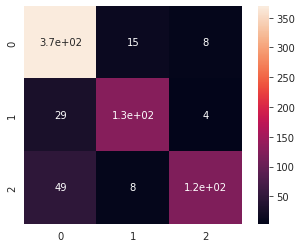

In [19]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, prediction)
#print(cm)
sns.heatmap(cm, annot=True)

#Check results on a few select images
n=np.random.randint(0, X_test.shape[0])
img = X_test[n]
plt.imshow(img)
input_img = np.expand_dims(img, axis=0) #Expand dims so the input is (num images, x, y, c)
input_img_feature=VGG_model.predict(input_img)
input_img_features=input_img_feature.reshape(input_img_feature.shape[0], -1)
p = model.predict(input_img_features)[0] 
p = le.inverse_transform([p])  #Reverse the label encoder to original name
print("The prediction for this image is: ", p)
print("The actual label for this image is: ", y_test[n])

In [20]:
from sklearn.metrics import f1_score, classification_report

print(f1_score(y_test, prediction, average='macro'))
print(classification_report(y_test, prediction))

0.8265613765771795
              precision    recall  f1-score   support

           0       0.83      0.94      0.88       392
           1       0.85      0.80      0.82       161
           2       0.91      0.68      0.78       179

    accuracy                           0.85       732
   macro avg       0.86      0.81      0.83       732
weighted avg       0.85      0.85      0.84       732

